In [18]:
%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
import PIL.Image
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath
import utils
from importlib import reload

In [20]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/rosout_agg', 'rosgraph_msgs/Log'],
 ['/rosout', 'rosgraph_msgs/Log'],
 ['/tf', 'tf2_msgs/TFMessage'],
 ['/dvrk/ECM/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/PSM1/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/PSM1/state_jaw_current', 'sensor_msgs/JointState'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/PSM3/state_jaw_current', 'sensor_msgs/JointState'],
 ['/dvrk/PSM3/current_state', 'std_msgs/String'],
 ['/dvrk/publishers/period_statistics', 'cisst_msgs/mtsIntervalStatistics'],
 ['/dvrk/tf_broadcast/period_statistics', 'cisst_msgs/mtsIntervalStatistics'],
 ['/dvrk/spin/period_statistics', 'cisst_msgs/mtsIntervalStatistics'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/ECM/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/position_cartesian_local_desired', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/position_cartesian_current

In [21]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    print("left or right image not receieved")
    time.sleep(0.5)
    

Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now
Removing previous callback, only one redirection possible right now


left or right image not receieved


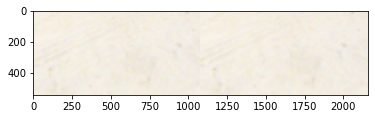

In [22]:
plt.imshow(np.hstack((left_image, right_image)))

In [23]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

['ECM',
 'ECM_base',
 'PSM1',
 'PSM1_base',
 'PSM2',
 'PSM2_base',
 'PSM3',
 'PSM3_base',
 'ECM_RCM',
 'PSM3_RCM',
 'PSM2_RCM',
 'PSM1_RCM',
 'PSM1_clip',
 'PSM2_clip',
 'simcamera',
 'PSM3_clip']

In [29]:
psm1 = dvrk.psm('PSM1')
psm2 = dvrk.psm('PSM2')
psm3 = dvrk.psm('PSM3')
ecm = dvrk.ecm('ECM')

psm1_suj = dvrk.suj('PSM1')
psm2_suj = dvrk.suj('PSM2')
psm3_suj = dvrk.suj('PSM3')
ecm_suj = dvrk.suj('ECM')


while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [30]:
print(psm1_suj.get_current_joint_position())
print(psm2_suj.get_current_joint_position())
print(psm3_suj.get_current_joint_position())
print(ecm_suj.get_current_joint_position())

[ 0.08        1.22173047 -1.74532926  0.17453292  0.        ]
[ 0.08        1.22173047 -1.74532926  0.17453292  0.        ]
[ 0.60000002  0.78539819 -1.57079637  0.78539819]
[ 0.08       -1.22173047  1.74532926 -0.17453292  0.        ]


In [26]:
# ECM_STARTING_JOINT_POS = np.asarray([-0.15669435,  0.17855662,  0.07069676,  0.17411496])
# ECM_STARTING_JOINT_POS = np.asarray([0.0615668 , 0.0523214 , 0.04854392, 0.15809197])
# ECM_STARTING_JOINT_POS = np.asarray([-0.14478268, -0.1293848 ,  0.00261061,  0.043541  ])
ECM_STARTING_JOINT_POS = np.asarray([0, -0.1 ,  0.05,  0.043541  ])
ecm.move_joint(ECM_STARTING_JOINT_POS)


True

In [27]:
time.sleep(1)
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm1.move_joint(PSM_HOME_POS)
psm1.close_jaw()

psm2.move_joint(PSM_HOME_POS)
psm2.close_jaw()

psm3.move_joint(PSM_HOME_POS)
psm3.close_jaw()

True

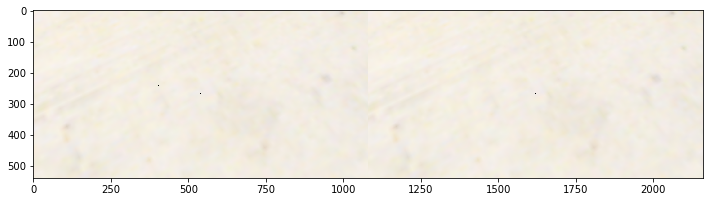

In [28]:
import image_geometry
utils = None
import utils
stereo_model = image_geometry.StereoCameraModel()
stereo_model.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = utils.tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'simcamera', rospy.Time()))
tf_world_to_psm1 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))
tf_world_to_psm3 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))

objects, frame = utils.get_points_and_img(left_image_msg, right_image_msg, stereo_model, tf_cam_to_world)
plt.figure(figsize=(12, 5))
plt.imshow(frame)
for o in objects:
    o = PyKDL.Vector(o.x(), o.y(), o.z())
#     o = PyKDL.Vector(o.x(), o.y(), o.z())

In [13]:
len(objects)

12

In [14]:
# pair up points that are across from each other
# x is *more or less* the axis along the wound
paired_pts = []
while objects:
    pt = objects[0]
    objects.remove(pt)
#     pt2 = min(objects, key=lambda obj : abs(obj.x() - pt.x()))
    pt2 = min(objects, key=lambda obj : abs(obj.y() - pt.y()))
    objects.remove(pt2)
#     paired_pts.append(
#         (max(pt, pt2, key=lambda p: p.y()), min(pt, pt2, key=lambda p: p.y())))
    paired_pts.append(
        (max(pt, pt2, key=lambda p: p.x()), min(pt, pt2, key=lambda p: p.x())))

z_val = paired_pts[0][0][2]
print(len(paired_pts)*2-1)
for i in range(len(paired_pts)):
    paired_pts[i][0][2] = z_val
    paired_pts[i][1][2] = z_val
    
print(paired_pts[0][0][1])
print(paired_pts[1][0][1])
paired_pts = sorted(paired_pts,key=lambda p: float(p[0][1]))
print("paired points sorted:")
paired_pts

11
0.0361944867878482
0.02409147418367738
paired points sorted:


[([    -1.51439,  -0.0276968,    0.647094],
  [    -1.52878,  -0.0274305,    0.647094]),
 ([    -1.51174,  -0.0132968,    0.647094],
  [    -1.52725,  -0.0122957,    0.647094]),
 ([    -1.50877, -0.00136464,    0.647094],
  [    -1.52608,-0.000189877,    0.647094]),
 ([    -1.51015,   0.0109381,    0.647094],
  [    -1.52649,   0.0106897,    0.647094]),
 ([    -1.51149,   0.0240915,    0.647094],
  [    -1.52709,   0.0237553,    0.647094]),
 ([    -1.51227,   0.0361945,    0.647094],
  [    -1.52876,   0.0358238,    0.647094])]

In [17]:
import suturing_state_machine
reload(suturing_state_machine)
reload(utils)
import time

pts_psm1 = paired_pts[0:2]
pts_psm2 = paired_pts[2:4]
pts_psm3 = paired_pts[4:6]

# double PSM same dir
# sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, pts_psm1, arm_name = 'PSM1')  
# sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')

# start_time = time.clock()
# while not sm1.is_done() or not sm2.is_done():
#     sm1.run_once()
#     sm2.run_once()
#     time.sleep(0.1)
    
# completion_time = time.clock() - start_time
# print("completion time(s): ",completion_time)

# single PSM 
# pts_psm2 = paired_pts

# sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')

# start_time = time.clock()
# while not sm2.is_done():
#     sm2.run_once()
#     time.sleep(0.1)
    
# completion_time = time.clock() - start_time
# print("completion time(s): ",completion_time)

# double PSM opposite dir
pts_psm1 = []
sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, pts_psm1, arm_name = 'PSM1')  
sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')
sm3 = suturing_state_machine.SuturingStateMachine(psm3, tf_world_to_psm3, pts_psm3, arm_name = 'PSM3')

for sublist in (paired_pts[:3]):
    pts_psm1.append(sublist[::-1])

start_time = time.time()

print("pts_psm1:", pts_psm1)
print("pts_psm2:", pts_psm2)
print("pts_psm3:", pts_psm2)


while not sm1.is_done() or not sm2.is_done():
    sm1.run_once()
    sm2.run_once()
    sm3.run_once()
    time.sleep(0.1)
    


pts_psm1: [([    -1.52878,  -0.0274305,    0.647094], [    -1.51439,  -0.0276968,    0.647094]), ([    -1.52725,  -0.0122957,    0.647094], [    -1.51174,  -0.0132968,    0.647094]), ([    -1.52608,-0.000189877,    0.647094], [    -1.50877, -0.00136464,    0.647094])]
pts_psm2: [([    -1.50877, -0.00136464,    0.647094], [    -1.52608,-0.000189877,    0.647094]), ([    -1.51015,   0.0109381,    0.647094], [    -1.52649,   0.0106897,    0.647094])]
pts_psm3: [([    -1.50877, -0.00136464,    0.647094], [    -1.52608,-0.000189877,    0.647094]), ([    -1.51015,   0.0109381,    0.647094], [    -1.52649,   0.0106897,    0.647094])]


KeyboardInterrupt: 

In [ ]:
dir(psm1)

In [ ]:
ecm.get_current_joint_position()

In [ ]:
psm2.close_jaw()